In [ ]:
# basic libraries import
import os
import re
import time
import math
import string
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import KeyedVectors
import helpers.data_mining_helpers as dmh
from scipy.sparse import csr_matrix, vstack, hstack

In [ ]:
# nltk library
import nltk
from nltk.corpus import stopwords

In [ ]:
# sklearn library
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, classification_report

In [ ]:
# keras library
# preprocess
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# model
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding
from keras.layers import ReLU, Softmax
from keras.callbacks import Callback
# RNN
from keras.layers import Dropout, LSTM, Bidirectional, CuDNNLSTM, CuDNNGRU
# CNN
from keras.layers import GlobalMaxPooling1D, GlobalMaxPool1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten
from keras.layers import Concatenate
# load model
from keras.models import model_from_json

Using TensorFlow backend.


In [ ]:
# plz setting your own relative data_path for trainning set
# plz import the necessary file by your own
# or just comment out the part you don't need to import
dir_data = 'data'

f_train_df = os.path.join(dir_data, 'train_df.pkl')
f_test_df = os.path.join(dir_data, 'test_df.pkl')
f_public_test_df = os.path.join(dir_data, 'public_test_df.pkl')
f_test_submission = os.path.join(dir_data, 'task1_sample_submission.csv')

# read file and convert into pandas dataframe
train_df = pd.read_pickle(f_train_df)
test_df = pd.read_pickle(f_test_df)
public_test_df = pd.read_pickle(f_public_test_df)
test_submission = pd.read_csv(f_test_submission)

In [ ]:
# utils
def label_decode(le, vec):
    dec = np.where(vec > 0.5, 1, 0)
    return dec

In [ ]:
# csv_logger
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('logs/training_log.csv')

In [ ]:
# micro f1 score metrics
class Metrics(Callback):
    def on_train_begin(self, logs=None):
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = label_decode(label_encoder, y_pred)
        y_true = label_decode(label_encoder, self.validation_data[1])
        _val_f1 = f1_score(y_true, y_pred, average='micro')
        self.val_f1s.append(_val_f1)
        print(classification_report(y_true=y_true, y_pred=y_pred))
        print(_val_f1)
    
metrics = Metrics()

---
---

#### data preprocess

In [ ]:
train_df['label'] = train_df['Task'].apply(lambda t : t.split('/'))
test_df['label'] = test_df['Task'].apply(lambda t : t.split('/'))

#### sentence preprocess

In [ ]:
train_df.head()

,Sentence,Task,Doc_no.,Rank,Rank%,Num_of_sentences,Is_first,Is_last,label
0,While service-dominant logic proposes that all...,BACKGROUND,5848,0,0.000000,9,1,0,[BACKGROUND]
1,Three longitudinal case studies in B2B equipme...,OBJECTIVES,5848,1,0.111111,9,0,0,[OBJECTIVES]
2,"We found the nature of value, degree of contex...",METHODS,5848,2,0.222222,9,0,0,[METHODS]
3,"To counter this, the firm uses (a) Direct Serv...",METHODS,5848,3,0.333333,9,0,0,[METHODS]
4,The co-creation of complex multidimensional va...,METHODS,5848,4,0.444444,9,0,0,[METHODS]


In [ ]:
punctuations = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~' + "“”"

In [ ]:
term_convert_dict = dmh.term_convert_dict_easy
stopwords = dmh.stop_word_to_remove

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#+_]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z ]')
TRANSLATOR = str.maketrans(punctuation, ' ' * len(punctuation))
STOPWORDS = set(stopwords.words('english'))

In [ ]:
# utils
def clean_text(text):
    text = text.lower()
#     tokens = nltk.word_tokenize(text)
#     tokens = [w for w in tokens if not w in stopwords] 
#     text = ' '.join(tokens)
    
    return text

In [ ]:
def df_preprocess(df):
    # text preprocess   
    df['p_text'] = df['Sentence'].apply(clean_text)
#     df['p_text'] = df['p_text'].str.replace('\d+', '')
    df['tmp'] = df['p_text'].apply(lambda s : nltk.word_tokenize(s))

    # replace common terms with words in pre-trained model
    df['tmp'] = df['tmp'].apply(lambda u : [term_convert_dict[w] if w in term_convert_dict else w for w in u])

    df['p_text'] = df['tmp'].apply(lambda a : ' '.join(a))
    
    df.drop(['tmp'], axis=1, inplace=True)

In [ ]:
start = time.time()

df_preprocess(train_df)
train_df.head()

print(f'time : {time.time() - start} sec')

time : 5.345385313034058 sec


In [ ]:
start = time.time()

df_preprocess(test_df)
train_df.head()

print(f'time : {time.time() - start} sec')

In [ ]:
start = time.time()

df_preprocess(test_df)
df_preprocess(public_test_df)

print(f'time : {time.time() - start} sec')

time : 18.351952075958252 sec


---
---

#### load pre-train model

In [ ]:
# GoogleNews
model_path = "data/GoogleNews-vectors-negative300.bin.gz"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

print('load ok')

load ok


In [ ]:
# GloVe Wikipedia 2014 + Gigaword 5
model_path = "data/glove.6B/word2vec.6B.300d.txt"
w2v_glove_wiki_300_model = KeyedVectors.load_word2vec_format(model_path, binary=False)

print('load ok')

load ok


In [ ]:
# GloVe Common Crawl
model_path = "data/glove.42B/word2vec.42B.300d.txt"
w2v_glove_300_model = KeyedVectors.load_word2vec_format(model_path, binary=False)

print('load ok')

load ok


---
---

#### RNN train data prepare

In [ ]:
df = train_df
word_model = w2v_glove_300_model
# word_model = w2v_glove_wiki_200_model

In [ ]:
MAX_NB_WORDS = 5000
MAX_LENGTH = 60
EMBEDDING_DIM = word_model.vector_size

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters="", lower=True)
tokenizer.fit_on_texts(df['p_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 32938 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['p_text'].values)
X = pad_sequences(X, maxlen=MAX_LENGTH, padding='post')
print('Shape of data tensor:', X.shape)

Shape of data tensor: (37551, 60)


In [ ]:
label_encoder = MultiLabelBinarizer()
enc = label_encoder.fit_transform(df['label'])
# Y = to_categorical(enc)
Y = enc.astype("float32")

print('Shape of label tensor:', Y.shape)

Shape of label tensor: (37551, 6)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 22)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(30040, 60) (30040, 6)
(7511, 60) (7511, 6)


In [ ]:
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if word in word_model.vocab:
        embedding_matrix[i] = word_model[word]

In [ ]:
embedding_matrix.shape

(32939, 300)

In [ ]:
N = 5000
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix[:N], axis=1))
nonzero_elements / N

In [ ]:
aa = np.count_nonzero(embedding_matrix[:N], axis=1)
idx = np.where(aa == 0)[0]

In [ ]:
for key, val in word_index.items():
    if val in idx:
        print(key)

---
---

#### RNN

In [ ]:
# pre-train embedding
embedding_layer = Embedding(vocab_size, 
                            EMBEDDING_DIM, 
                            weights=[embedding_matrix],
#                             mask_zero=True,
                            input_length=MAX_LENGTH, 
                            trainable=False)

In [ ]:
kernel_size = 2
filters = 256
pool_size = 2

hidden_nodes = 128
classes = len(label_encoder.classes_)

In [ ]:
RNN = Sequential()
RNN.add(embedding_layer)

RNN.add(Bidirectional(CuDNNGRU(hidden_nodes, return_sequences=True)))
RNN.add(Bidirectional(CuDNNGRU(hidden_nodes)))

RNN.add(Dense(classes, activation='sigmoid'))
RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 8
batch_size = 32

# cost time calculation
start = time.time()

# RNN.summary()

history = RNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, Y_test), callbacks=[metrics, csv_logger])

print(f'time : {time.time() - start} sec')

Train on 30040 samples, validate on 7511 samples
Epoch 1/8
30040/30040 [==============================] - 14s 456us/step - loss: 0.3490 - acc: 0.8515 - val_loss: 0.3262 - val_acc: 0.8631
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      2166
           1       0.72      0.02      0.04       825
           2       0.64      0.57      0.60      2212
           3       0.66      0.33      0.44      1439
           4       0.85      0.08      0.15       132
           5       0.74      0.55      0.63      1910

   micro avg       0.70      0.51      0.59      8684
   macro avg       0.72      0.38      0.43      8684
weighted avg       0.70      0.51      0.56      8684
 samples avg       0.58      0.54      0.55      8684

0.5906164974450859
Epoch 2/8
  512/30040 [..............................] - ETA: 11s - loss: 0.3102 - acc: 0.8662

C:\Users\pclightyear\Anaconda3\envs\Data_Mining\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


30040/30040 [==============================] - 12s 413us/step - loss: 0.3114 - acc: 0.8684 - val_loss: 0.3152 - val_acc: 0.8652
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      2166
           1       0.48      0.18      0.26       825
           2       0.68      0.54      0.60      2212
           3       0.71      0.21      0.33      1439
           4       0.72      0.14      0.23       132
           5       0.69      0.65      0.67      1910

   micro avg       0.71      0.52      0.60      8684
   macro avg       0.68      0.41      0.47      8684
weighted avg       0.69      0.52      0.57      8684
 samples avg       0.57      0.54      0.54      8684

0.5961295471171112
Epoch 3/8
30040/30040 [==============================] - 13s 420us/step - loss: 0.2918 - acc: 0.8770 - val_loss: 0.3153 - val_acc: 0.8666
              precision    recall  f1-score   support

           0       0.82      0.67      0.74      2166
         

In [ ]:
# import the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/training_log.csv")
training_log.head()

,epoch,acc,loss,val_acc,val_loss
0,0,0.851509,0.349044,0.863112,0.326181
1,1,0.868448,0.311365,0.865242,0.315208
2,2,0.877042,0.291757,0.866573,0.315335
3,3,0.887228,0.269400,0.866973,0.317622
4,4,0.900871,0.239993,0.863400,0.332058


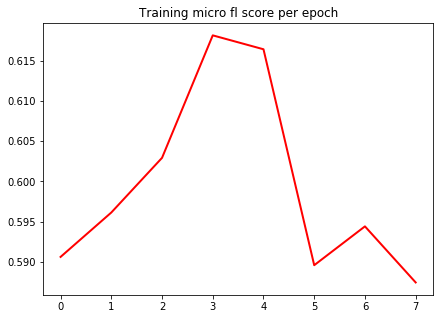

In [ ]:
plt.figure(figsize=(7, 5))

# plot validation macro fl score per epoch
# plt.subplot(121)
index = np.arange(epochs)
plt.plot(index, metrics.val_f1s, marker='', color='r', linewidth=2)

plt.title('Training micro fl score per epoch')

# plot training and validation loss per epoch
# plt.subplot(122)
# plt.plot('epoch', 'loss', data=training_log, marker='', color='b', linewidth=2)
# plt.plot('epoch', 'val_loss', data=training_log , marker='', color='r', linewidth=2)

# plt.title('Training Loss per epoch')
# plt.legend()

# plt.show()  
plt.savefig('f1score_per_epoch.png')

In [ ]:
model = RNN

In [ ]:
# save model
model_json = model.to_json()
with open("models/RNN_v1.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model.save_weights("models/RNN_v1.h5")
print("Saved model to disk")

---
---

### validation

#### RNN

In [ ]:
model = RNN
df = test_df
batch_size = 32

In [ ]:
X_private_test = tokenizer.texts_to_sequences(df['p_text'].values)
X_private_test = pad_sequences(X_private_test, maxlen=MAX_LENGTH, padding='post')
print('Shape of data tensor:', X_private_test.shape)

Shape of data tensor: (9316, 60)


In [ ]:
Y_private_test_pred = model.predict(X_private_test, batch_size=batch_size)

In [ ]:
Y_private_test_pred_de = label_decode(label_encoder, Y_private_test_pred)

In [ ]:
y_true = label_encoder.transform(df['label'])
y_pred = Y_private_test_pred_de

In [ ]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVES', 'OTHERS',
       'RESULTS'], dtype=object)

In [ ]:
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

  BACKGROUND       0.75      0.69      0.72      2709
 CONCLUSIONS       0.39      0.19      0.26      1042
     METHODS       0.60      0.65      0.62      2585
  OBJECTIVES       0.62      0.41      0.49      1887
      OTHERS       0.35      0.18      0.24       179
     RESULTS       0.65      0.61      0.63      2349

   micro avg       0.64      0.56      0.60     10751
   macro avg       0.56      0.46      0.49     10751
weighted avg       0.63      0.56      0.58     10751
 samples avg       0.60      0.58      0.58     10751



In [ ]:
print(f1_score(y_true, y_pred, average='micro'))

0.6087408408252352


---
---

### Generate Prediction

In [ ]:
# load model
# load json and create model
json_file = open('models/RNN_v1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("models/RNN_v1.h5")
print("Loaded model from disk")

In [ ]:
N = len(public_test_df)
N

131166

In [ ]:
model = model
df = public_test_df
batch_size = 32

In [ ]:
X_public_test = tokenizer.texts_to_sequences(df['p_text'].values)
X_public_test = pad_sequences(X_public_test, maxlen=MAX_LENGTH, padding='post')
print('Shape of data tensor:', X_public_test.shape)

Shape of data tensor: (131166, 60)


In [ ]:
Y_public_test_pred = model.predict(X_public_test, batch_size=batch_size)
Y_public_test_pred_de = label_decode(label_encoder, Y_public_test_pred)

In [ ]:
y_pred = Y_public_test_pred_de
y_pred.shape

(131166, 6)

In [ ]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVES', 'OTHERS',
       'RESULTS'], dtype=object)

In [ ]:
for i, task in enumerate(label_encoder.classes_):
    test_submission.loc[:N-1, task] = y_pred[:, i]

In [ ]:
test_submission.head()

,order_id,BACKGROUND,OBJECTIVES,METHODS,RESULTS,CONCLUSIONS,OTHERS
0,T00001_S001,1,0,0,0,0,0
1,T00001_S002,1,0,0,0,0,0
2,T00001_S003,0,0,0,0,0,0
3,T00001_S004,0,1,0,0,0,0
4,T00001_S005,0,0,0,1,0,0


In [ ]:
test_submission.to_csv('submission.csv', index=False)